In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data/listings.csv")

In [3]:
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20250305023444,2025-03-08,city scrape,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.34
1,40625,https://www.airbnb.com/rooms/40625,20250305023444,2025-03-05,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.61,4.72,NaN,f,14,13,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20250305023444,2025-03-08,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.87,4.59,NaN,t,3,3,0,0,2.22
3,109679,https://www.airbnb.com/rooms/109679,20250305023444,2025-03-07,city scrape,Near Palace Schönbrunn - Apt. 4,Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/1982234/1fc34...,175131,...,4.91,4.65,4.82,NaN,f,14,13,1,0,0.91
4,114505,https://www.airbnb.com/rooms/114505,20250305023444,2025-03-05,city scrape,"Near Palace Schönbrunn, Apt. 5",Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11536257/9065...,175131,...,4.96,4.71,4.80,NaN,f,14,13,1,0,0.74


In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
data['price_numeric'] = pd.to_numeric(
    data['price'].astype(str).str.replace(r'[\$,]', '', regex=True),
    errors='coerce'
)


In [6]:
print(list(data.columns.values))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

In [7]:
# Cell 4: Normalization Function and Implementation
def normalize(X):
    """
    Normalize features to have zero mean and unit variance.
    
    Parameters:
    X (pandas.DataFrame or numpy.array): Input features
    
    Returns:
    X_normalized (pandas.DataFrame or numpy.array): Normalized features
    means (pandas.Series or numpy.array): Mean values used for normalization
    stds (pandas.Series or numpy.array): Standard deviations used for normalization
    """
    means = X.mean()
    stds = X.std()
    X_normalized = (X - means) / stds
    return X_normalized, means, stds

In [8]:
# Cell 6: Data Exploration and Feature Selection
print("Dataset shape:", data.shape)
print("\nTarget variable (price_numeric) statistics:")
print(data['price_numeric'].describe())

# Check for missing values in key columns
print("\nMissing values in potential features:")
potential_features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 
                     'review_scores_rating', 'availability_365', 'minimum_nights',
                     'latitude', 'longitude', 'host_is_superhost', 'instant_bookable',
                     'calculated_host_listings_count', 'reviews_per_month']

for col in potential_features:
    if col in data.columns:
        missing_count = data[col].isnull().sum()
        print(f"{col}: {missing_count} ({missing_count/len(data)*100:.1f}%)")


Dataset shape: (13790, 80)

Target variable (price_numeric) statistics:
count     9821.000000
mean       124.060992
std        440.491994
min         13.000000
25%         57.000000
50%         80.000000
75%        116.000000
max      15210.000000
Name: price_numeric, dtype: float64

Missing values in potential features:
accommodates: 0 (0.0%)
bedrooms: 1400 (10.2%)
beds: 3975 (28.8%)
bathrooms: 3958 (28.7%)
number_of_reviews: 0 (0.0%)
review_scores_rating: 2569 (18.6%)
availability_365: 0 (0.0%)
minimum_nights: 0 (0.0%)
latitude: 0 (0.0%)
longitude: 0 (0.0%)
host_is_superhost: 258 (1.9%)
instant_bookable: 0 (0.0%)
calculated_host_listings_count: 0 (0.0%)
reviews_per_month: 2569 (18.6%)


In [9]:
# Cell 7: Feature Engineering and Preprocessing
# Create binary variables for categorical features
data['host_is_superhost_binary'] = (data['host_is_superhost'] == 't').astype(int)
data['instant_bookable_binary'] = (data['instant_bookable'] == 't').astype(int)

# Handle room_type - create dummy variables
room_type_dummies = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, room_type_dummies], axis=1)

# Handle property_type - keep only most common types
property_type_counts = data['property_type'].value_counts()
top_property_types = property_type_counts.head(5).index
data['property_type_simplified'] = data['property_type'].apply(
    lambda x: x if x in top_property_types else 'Other'
)
property_type_dummies = pd.get_dummies(data['property_type_simplified'], prefix='property_type')
data = pd.concat([data, property_type_dummies], axis=1)

In [10]:
# Cell 8: Feature Selection for Model
# Select features for the model
feature_columns = [
    # Numerical features
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'latitude', 'longitude',
    'calculated_host_listings_count', 'reviews_per_month',
    
    # Binary features
    'host_is_superhost_binary', 'instant_bookable_binary',
    
    # Room type dummies (exclude one to avoid multicollinearity)
    'room_type_Entire home/apt', 'room_type_Private room',
    
    # Property type dummies (exclude one to avoid multicollinearity)
]

# Add property type dummies to feature list (excluding one category)
property_dummies = [col for col in data.columns if col.startswith('property_type_')]
if property_dummies:
    feature_columns.extend(property_dummies[:-1])  # Exclude last one

# Add review scores if available and not too many missing values
review_score_cols = ['review_scores_rating', 'review_scores_cleanliness', 
                    'review_scores_location', 'review_scores_value']
for col in review_score_cols:
    if col in data.columns and data[col].isnull().sum() < len(data) * 0.5:
        feature_columns.append(col)

print("Selected features:", feature_columns)

Selected features: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'availability_365', 'minimum_nights', 'latitude', 'longitude', 'calculated_host_listings_count', 'reviews_per_month', 'host_is_superhost_binary', 'instant_bookable_binary', 'room_type_Entire home/apt', 'room_type_Private room', 'property_type_simplified', 'property_type_Entire condo', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Other', 'property_type_Private room in rental unit', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value']


In [11]:
# Cell 9: Data Cleaning and Preparation (Revised)

# Remove rows with missing target values
clean_data = data.dropna(subset=['price_numeric']).copy()

# Remove extreme outliers in price (beyond 3 standard deviations)
price_mean = clean_data['price_numeric'].mean()
price_std = clean_data['price_numeric'].std()
clean_data = clean_data[
    (clean_data['price_numeric'] >= price_mean - 3*price_std) &
    (clean_data['price_numeric'] <= price_mean + 3*price_std)
]

# Cell 7: Feature Engineering and Preprocessing (Merged and Corrected)
# Create binary variables for categorical features
clean_data['host_is_superhost_binary'] = (clean_data['host_is_superhost'] == 't').astype(int)
clean_data['instant_bookable_binary'] = (clean_data['instant_bookable'] == 't').astype(int)

# Handle room_type - create dummy variables
room_type_dummies = pd.get_dummies(clean_data['room_type'], prefix='room_type')
clean_data = pd.concat([clean_data, room_type_dummies], axis=1)

# Handle property_type - keep only most common types
property_type_counts = clean_data['property_type'].value_counts()
top_property_types = property_type_counts.head(5).index
clean_data['property_type_simplified'] = clean_data['property_type'].apply(
    lambda x: x if x in top_property_types else 'Other'
)
property_type_dummies = pd.get_dummies(clean_data['property_type_simplified'], prefix='property_type')
data_with_dummies = pd.concat([clean_data, property_type_dummies], axis=1)

# Handle neighborhood_cleansed - create dummy variables
neighbourhood_dummies = pd.get_dummies(data_with_dummies['neighbourhood_cleansed'], prefix='neighbourhood')
data_with_dummies = pd.concat([data_with_dummies, neighbourhood_dummies], axis=1)


# Cell 8: Feature Selection for Model (Merged and Corrected)
# Select features for the model
feature_columns = [
    # Numerical features
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'latitude', 'longitude',
    'calculated_host_listings_count', 'reviews_per_month',
    
    # Binary features
    'host_is_superhost_binary', 'instant_bookable_binary',
    
    # Room type dummies (exclude one to avoid multicollinearity)
    'room_type_Entire home/apt', 'room_type_Private room',
    
    # Property type dummies (excluding one for multicollinearity)
    *list(property_type_dummies.columns.drop('property_type_Other')), # Example: drop 'Other'
    
    # Neighborhood dummies (excluding one for multicollinearity)
    *list(neighbourhood_dummies.columns.drop(neighbourhood_dummies.columns[0])) # Drop the first one
]

# Add review scores if available and not too many missing values
review_score_cols = ['review_scores_rating', 'review_scores_cleanliness', 
                    'review_scores_location', 'review_scores_value']
for col in review_score_cols:
    if col in data_with_dummies.columns and data_with_dummies[col].isnull().sum() < len(data_with_dummies) * 0.5:
        feature_columns.append(col)

# Ensure no duplicate columns are in the list
feature_columns = list(dict.fromkeys(feature_columns))

print("Selected features:", feature_columns)
print(f"Number of features: {len(feature_columns)}")

# Prepare feature matrix
X = data_with_dummies[feature_columns].copy()

# Handle missing values in features
# For numerical columns, fill with median
numerical_cols = X.select_dtypes(include=np.number).columns
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

# For any remaining missing values, fill with 0
X = X.fillna(0)

# Target variable
y = data_with_dummies['price_numeric']

print(f"Final dataset shape: {X.shape}")
print(f"Target variable range: ${y.min():.2f} - ${y.max():.2f}")

Selected features: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'availability_365', 'minimum_nights', 'latitude', 'longitude', 'calculated_host_listings_count', 'reviews_per_month', 'host_is_superhost_binary', 'instant_bookable_binary', 'room_type_Entire home/apt', 'room_type_Private room', 'property_type_Entire condo', 'property_type_Entire rental unit', 'property_type_Entire serviced apartment', 'property_type_Private room in rental unit', 'property_type_Room in hotel', 'neighbourhood_Brigittenau', 'neighbourhood_Donaustadt', 'neighbourhood_D\x9abling', 'neighbourhood_Favoriten', 'neighbourhood_Floridsdorf', 'neighbourhood_Hernals', 'neighbourhood_Hietzing', 'neighbourhood_Innere Stadt', 'neighbourhood_Josefstadt', 'neighbourhood_Landstra§e', 'neighbourhood_Leopoldstadt', 'neighbourhood_Liesing', 'neighbourhood_Margareten', 'neighbourhood_Mariahilf', 'neighbourhood_Meidling', 'neighbourhood_Neubau', 'neighbourhood_Ottakring', 'neighbourhood_Penzing', 'neighb

In [12]:
# Cell 10: Train-Test Split and Normalization
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features using the function you defined
def normalize(df):
    """
    Normalize features to have zero mean and unit variance.

    Parameters:
    df (pandas.DataFrame): Input features

    Returns:
    df_normalized (pandas.DataFrame): Normalized features
    means (pandas.Series): Mean values used for normalization
    stds (pandas.Series): Standard deviations used for normalization
    """
    means = df.mean()
    stds = df.std()
    # Handle the case where a feature has zero standard deviation
    stds[stds == 0] = 1
    df_normalized = (df - means) / stds
    return df_normalized, means, stds

X_train_normalized, means, stds = normalize(X_train)
X_test_normalized = (X_test - means) / stds

print(f"Training set shape: {X_train_normalized.shape}")
print(f"Test set shape: {X_test_normalized.shape}")

Training set shape: (7832, 53)
Test set shape: (1958, 53)


In [13]:
# Cell 11: Train Linear Regression Model
# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train_normalized, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_normalized)
y_test_pred = lr_model.predict(X_test_normalized)

In [14]:
# Cell 12: Model Evaluation
# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: ${np.sqrt(train_mse):.2f}")
print(f"Test RMSE: ${np.sqrt(test_mse):.2f}")

Model Performance:
Training MSE: 5805.82
Test MSE: 6101.89
Training R²: 0.2595
Test R²: 0.3117
Training RMSE: $76.20
Test RMSE: $78.11


In [15]:
# Cell 13: Feature Importance Analysis
# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                                      feature   coefficient  abs_coefficient
13                  room_type_Entire home/apt  5.836803e+13     5.836803e+13
14                  room_type_Entire home/apt -5.836803e+13     5.836803e+13
15                     room_type_Private room  4.917509e+12     4.917509e+12
16                     room_type_Private room -4.917509e+12     4.917509e+12
19           property_type_Entire rental unit -4.192913e+12     4.192913e+12
20           property_type_Entire rental unit  4.192913e+12     4.192913e+12
26                property_type_Room in hotel  2.159388e+12     2.159388e+12
25                property_type_Room in hotel -2.159388e+12     2.159388e+12
24  property_type_Private room in rental unit -1.149999e+12     1.149999e+12
23  property_type_Private room in rental unit  1.149999e+12     1.149999e+12


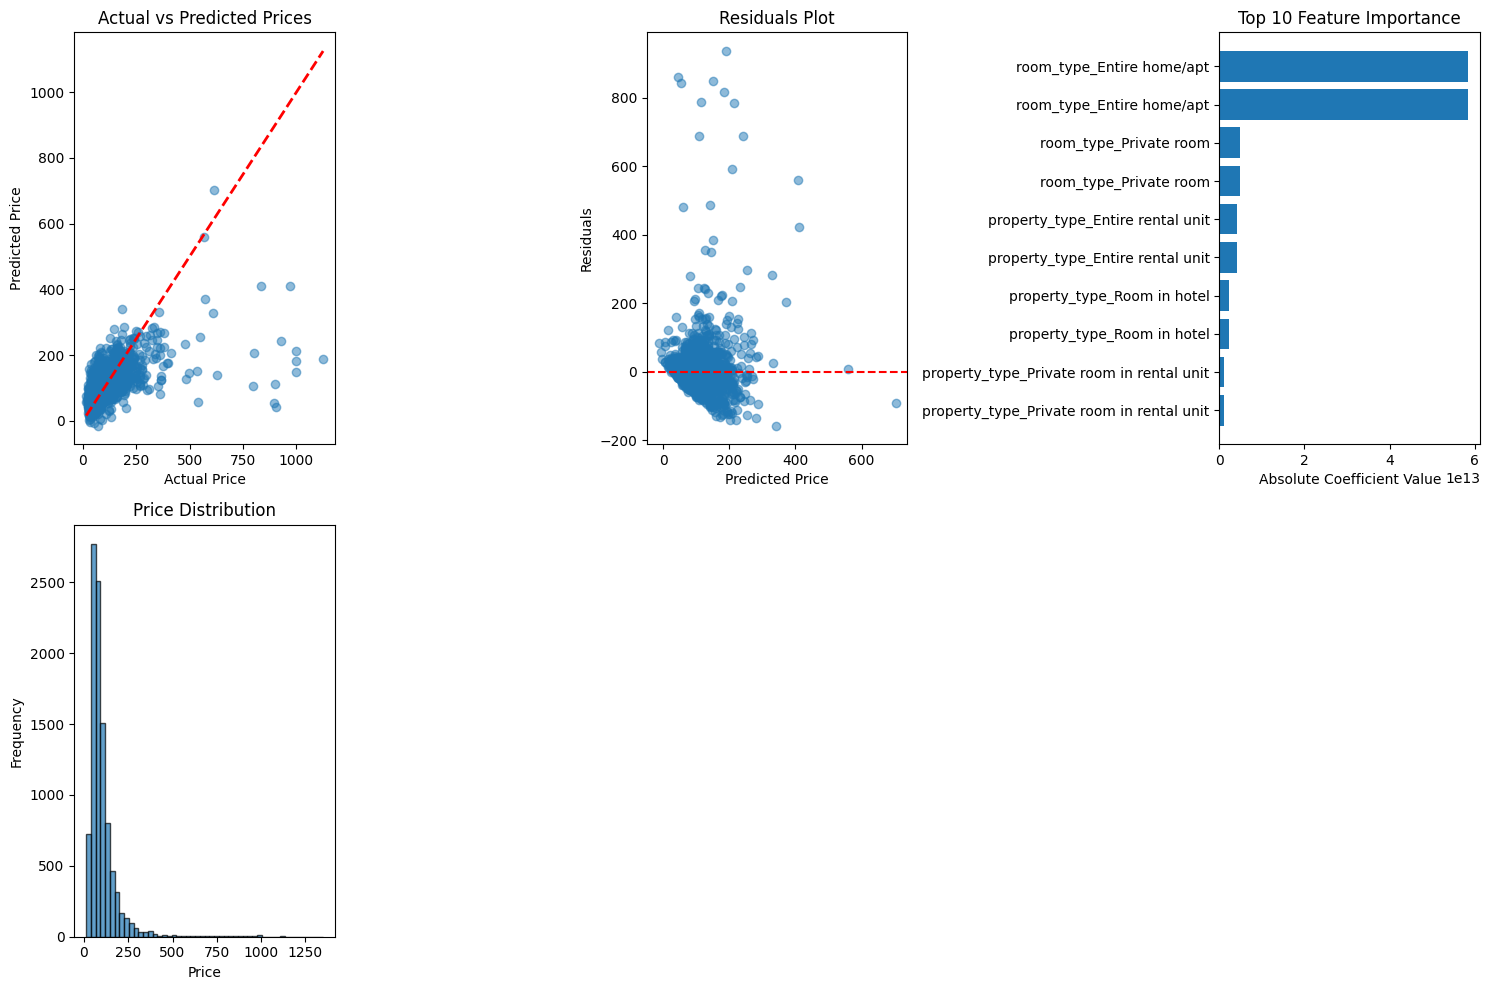

In [16]:
from scipy import stats

plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted scatter plot
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# 2. Residuals plot
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# 3. Feature importance bar plot
plt.subplot(2, 3, 3)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['abs_coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

# 4. Price distribution
plt.subplot(2, 3, 4)
plt.hist(y, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')

plt.tight_layout()
plt.show()